In [ ]:
import sympy as sp


def sym_basis_k_symbolic(k, d=3):
    basis = []

    # Factorials and sqrt become symbolic
    factorial = sp.factorial
    sqrt = sp.sqrt

    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            a, b, c = parts

            norm = sqrt(factorial(a) * factorial(b) * factorial(c) / factorial(k))
            basis.append((tuple(parts), sp.simplify(norm)))
            return

        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis


# Test
for vec, norm in sym_basis_k_symbolic(4):
    print(vec, norm)

(4, 0, 0) 1
(3, 1, 0) 1/2
(3, 0, 1) 1/2
(2, 2, 0) sqrt(6)/6
(2, 1, 1) sqrt(3)/6
(2, 0, 2) sqrt(6)/6
(1, 3, 0) 1/2
(1, 2, 1) sqrt(3)/6
(1, 1, 2) sqrt(3)/6
(1, 0, 3) 1/2
(0, 4, 0) 1
(0, 3, 1) 1/2
(0, 2, 2) sqrt(6)/6
(0, 1, 3) 1/2
(0, 0, 4) 1


Let $d=3$ and consider a matrix $M \in \mathbb{R}^{3 \times 3}$.  
Let $\alpha = (\alpha_0, \alpha_1, \alpha_2)$ and $\beta = (\beta_0, \beta_1, \beta_2)$ be multi-indices corresponding to basis vectors in $\mathrm{Sym}^k(\mathbb{R}^3)$.

We want the matrix element of the symmetric projection:

$$
\pi(M^{\otimes k})_{\alpha,\beta} = \sum_{T \in \mathcal{T}(\alpha,\beta)} 
\frac{k!}{\prod_{i,j} T_{ij}!} \prod_{i,j} M_{ij}^{T_{ij}}
$$

where $\mathcal{T}(\alpha,\beta)$ is the set of $3 \times 3$ matrices $T = (T_{ij})$ with row sums $\alpha$ and column sums $\beta$:

$$
\sum_{j=0}^2 T_{ij} = \alpha_i, \quad \sum_{i=0}^2 T_{ij} = \beta_j.
$$

---

*Recursive computation*

Define a recursive function to sum over all valid splits of $\alpha$ into contributions to $\beta$:

1. Start at row $u=0$ with remaining column sums $\beta^{(0)} = \beta$.  
2. Generate all partitions of $\alpha_0$ into three non-negative integers $(T_{0,0}, T_{0,1}, T_{0,2})$.  
3. For each valid split satisfying $T_{0,j} \le \beta^{(0)}_j$, update remaining column sums:

$$
\beta^{(1)}_j = \beta^{(0)}_j - T_{0,j}, \quad j=0,1,2
$$

4. Recurse to row $u=1$ with sum $\alpha_1$ and remaining column sums $\beta^{(1)}$.  
5. Continue to row $u=2$ with $\alpha_2$ and $\beta^{(2)}$.  
6. If all remaining column sums are zero at the last row, the split $T$ is valid.  
7. Contribution of $T$ to the sum:

$$
\text{term}(T) = \frac{k!}{\prod_{i,j} T_{ij}!} \prod_{i,j} M_{ij}^{T_{ij}}.
$$

---

*Recursive formula*

Let $f(\alpha, \beta, u)$ denote the recursive sum at row $u$:

$$
f(\alpha, \beta, u) =
\sum_{\substack{(T_{u,0},T_{u,1},T_{u,2}) \\ \sum_j T_{u,j} = \alpha_u \\ T_{u,j} \le \beta_j}}
\left[ \frac{\alpha_u!}{\prod_{j=0}^2 T_{u,j}!} 
\prod_{j=0}^2 M_{u,j}^{T_{u,j}} \cdot f(\alpha, \beta - T_{u,\cdot}, u+1) \right]
$$

with base case:

$$
f(\alpha, \beta, u=3) = 
\begin{cases}
1 & \text{if } \beta = (0,0,0),\\
0 & \text{otherwise}.
\end{cases}
$$

Finally, multiply by the basis norm factors to get the corresponding entry of the projected symmetric tensor:

$$
\pi(M^{\otimes k})_{\alpha,\beta} = \text{norm}_\alpha \cdot \text{norm}_\beta \cdot f(\alpha, \beta, 0)
$$


In [ ]:
import sympy as sp
from functools import lru_cache


def pi_symmetric_multinomial_opt(M, basis, numeric=False):
    """
    Compute the symmetric multinomial projection of M on the given basis.

    Args:
        M (sp.Matrix): d x d symbolic matrix.
        basis (list): List of (vector, norm) tuples from sym_basis_k_symbolic.
        numeric (bool): If True, evaluates numerically to speed up large k.

    Returns:
        sp.Matrix: Projected matrix.
    """
    d = M.rows
    n = len(basis)
    piM = sp.zeros(n, n)
    factorial = sp.factorial

    # Maximum degree k (all basis vectors have same degree)
    max_k = sum(basis[0][0])
    factorials = [factorial(i) for i in range(max_k + 1)]

    # Precompute powers of M
    powers = {}
    for u in range(d):
        for v in range(d):
            powers[(u, v)] = [1]  # M[u,v]^0
            val = 1
            for t in range(1, max_k + 1):
                val *= M[u, v]
                powers[(u, v)].append(val)

    # Function to enumerate contingency matrices
    def enum_contingency(rows, cols):
        @lru_cache(maxsize=None)
        def _recurse(row_idx, cols_remaining):
            cols_remaining = list(cols_remaining)
            if row_idx == len(rows):
                if all(c == 0 for c in cols_remaining):
                    return [()]
                return []
            results = []
            target = rows[row_idx]

            def compose(pos, left, current):
                if pos == len(cols_remaining) - 1:
                    val = left
                    if val <= cols_remaining[pos]:
                        yield tuple(current + [val])
                    return
                maxv = min(left, cols_remaining[pos])
                for v in range(maxv, -1, -1):
                    yield from compose(pos + 1, left - v, current + [v])

            for row_choice in compose(0, target, []):
                new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(len(cols_remaining)))
                for tail in _recurse(row_idx + 1, new_cols):
                    results.append(tuple(row_choice) + tail)
            return results

        return _recurse(0, tuple(cols))

    # Compute projection matrix
    for i_idx, (vec_i, norm_i) in enumerate(basis):
        for j_idx, (vec_j, norm_j) in enumerate(basis):
            val = 0
            for mat_flat in enum_contingency(tuple(vec_i), tuple(vec_j)):
                term = 1
                denom = 1
                for u in range(d):
                    for v in range(d):
                        t = mat_flat[u * d + v]
                        if t:
                            term *= powers[(u, v)][t]
                            denom *= factorials[t]
                val += factorials[max_k] / denom * term
            piM[i_idx, j_idx] = norm_i * norm_j * val
            if numeric:
                piM[i_idx, j_idx] = sp.N(piM[i_idx, j_idx])

    return piM

In [ ]:
# --- Test ---
d = 3
k_val = 2
M = sp.Matrix([[sp.symbols(f"M{i}{j}") for j in range(1, d + 1)] for i in range(1, d + 1)])
basis = sym_basis_k_symbolic(k_val, d)
piM = pi_symmetric_multinomial_opt(M, basis)
display(piM)

Matrix([
[         M11**2,   sqrt(2)*M11*M12,   sqrt(2)*M11*M13,          M12**2,   sqrt(2)*M12*M13,          M13**2],
[sqrt(2)*M11*M21, M11*M22 + M12*M21, M11*M23 + M13*M21, sqrt(2)*M12*M22, M12*M23 + M13*M22, sqrt(2)*M13*M23],
[sqrt(2)*M11*M31, M11*M32 + M12*M31, M11*M33 + M13*M31, sqrt(2)*M12*M32, M12*M33 + M13*M32, sqrt(2)*M13*M33],
[         M21**2,   sqrt(2)*M21*M22,   sqrt(2)*M21*M23,          M22**2,   sqrt(2)*M22*M23,          M23**2],
[sqrt(2)*M21*M31, M21*M32 + M22*M31, M21*M33 + M23*M31, sqrt(2)*M22*M32, M22*M33 + M23*M32, sqrt(2)*M23*M33],
[         M31**2,   sqrt(2)*M31*M32,   sqrt(2)*M31*M33,          M32**2,   sqrt(2)*M32*M33,          M33**2]])

In [ ]:
import sympy as sp
import random

# assume these functions are already defined from previous code:
# - sym_basis_k_symbolic
# - pi_symmetric_multinomial


def random_int_matrix(d, lo=-3, hi=3):
    """Generate a random integer dxd SymPy matrix."""
    return sp.Matrix([[random.randint(lo, hi) for _ in range(d)] for _ in range(d)])


def test_representation_property(d=3, k_val=4, trials=3):
    print(f"Testing π(AB) = π(A) π(B) for S^{k_val}(ℂ^{d}) ...\n")

    # fixed basis for this k and d
    basis = sym_basis_k_symbolic(k_val, d)

    for t in range(trials):
        print(f"--- Trial {t+1} ---")

        # Random integer matrices A, B
        A = random_int_matrix(d)
        B = random_int_matrix(d)
        AB = A * B

        print("A =", A)
        print("B =", B)

        # Compute symmetric power matrices
        piA = pi_symmetric_multinomial_opt(A, basis)
        piB = pi_symmetric_multinomial_opt(B, basis)
        piAB = pi_symmetric_multinomial_opt(AB, basis)

        # Compare
        diff = sp.simplify(piAB - (piA * piB))

        if diff == sp.zeros(*diff.shape):
            print("✅ PASS:  pi(AB) == pi(A)*pi(B)")
        else:
            print("❌ FAIL!")
            print("Difference:")
            display(diff)
            return False  # early stop

    print("\nAll tests passed ✅")
    return True


# Run the property test
if __name__ == "__main__":
    random.seed(0)
    test_representation_property(d=3, k_val=10, trials=3)

Testing π(AB) = π(A) π(B) for S^10(ℂ^3) ...

--- Trial 1 ---
A = Matrix([[3, 0, 3], [0, -3, -1], [1, 0, 0]])
B = Matrix([[3, 3, -1], [0, -1, 1], [-2, 1, -2]])
✅ PASS:  pi(AB) == pi(A)*pi(B)
--- Trial 2 ---
A = Matrix([[-1, -2, 3], [-3, 1, 3], [-1, 1, 2]])
B = Matrix([[3, 1, -2], [-1, -3, 2], [-3, 3, 2]])


KeyboardInterrupt: 

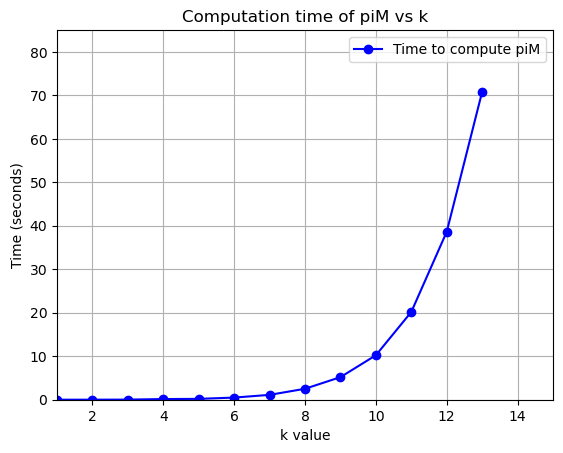

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Assume sym_basis_k_symbolic and pi_symmetric_multinomial are already defined
d = 3
M = sp.Matrix([[sp.symbols(f"M{i}{j}") for j in range(1, d + 1)] for i in range(1, d + 1)])

k_values = list(range(1, 16))
times = []

plt.figure(figsize=(8, 5))

for k_val in k_values:
    start = time.time()

    basis = sym_basis_k_symbolic(k_val, d)
    piM = pi_symmetric_multinomial_opt(M, basis)

    elapsed = time.time() - start
    times.append(elapsed)

    # Clear previous plot
    clear_output(wait=True)

    # Plot updated data
    plt.plot(k_values[: len(times)], times, "o-", color="blue", label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 15)
    plt.ylim(0, max(times) * 1.2)
    plt.show()

In [ ]:
import numpy as np
import sympy as sp

# --- symbolic π(M) setup ---
d = 3
k_val = 4

# symbolic 3×3 matrix
M_sym = sp.Matrix([[sp.symbols(f"M{i}{j}") for j in range(1, d + 1)] for i in range(1, d + 1)])
basis = sym_basis_k_symbolic(k_val, d)
piM_sym = pi_symmetric_multinomial_opt(M_sym, basis)
# display(piM_sym)

type(piM_sym)

sympy.matrices.dense.MutableDenseMatrix

In [13]:
display(piM_sym)

Matrix([
[                  M11**4,                                                            2*M11**3*M12,                                                            2*M11**3*M13,                                                                        sqrt(6)*M11**2*M12**2,                                                                                                            2*sqrt(3)*M11**2*M12*M13,                                                                        sqrt(6)*M11**2*M13**2,                                                            2*M11*M12**3,                                                                                                            2*sqrt(3)*M11*M12**2*M13,                                                                                                            2*sqrt(3)*M11*M12*M13**2,                                                            2*M11*M13**3,                   M12**4,                                                            

In [ ]:
import pickle

with open("file.pkl", "wb") as file:
    pickle.dump(piM_sym, file)

# Heuristic Experiment for Symmetric 2nd-Order Representation

We want to heuristically reconstruct the kernel of the symmetric 2nd-order representation $\pi(M)$ using a set of test matrices $M_k \in \mathbb{R}^{d \times d}$.

---

## 1. Binary Matrices Generation

Let $d=3$ and define all positions in a $3 \times 3$ matrix:

$$
\text{all\_pos} = \{(i,j) \mid i,j = 0,1,2 \}.
$$

We generate a list of matrices $M_k$ with progressively more nonzero entries:

$$
M_k \in \{ \text{matrices with 1-one, 2-ones, ..., up to num\_matrices} \}.
$$

---

## 2. Symbolic Evaluation

Given a symbolic representation $\pi M_\text{sym} \in \mathbb{R}^{6 \times 6}$, define a function

$$
\pi_\text{func}: \mathbb{R}^{d^2} \to \mathbb{R}^{6 \times 6}, \quad M \mapsto \pi(M)
$$

by substituting the entries of $M$ into $\pi M_\text{sym}$.

---

## 3. Lambda Nullspace

For the first $j$ matrices, vectorize the $\pi(M_k)$ and form

$$
A_j = \big[ \operatorname{vec}(\pi(M_1)) \;\; \operatorname{vec}(\pi(M_2)) \;\; \dots \;\; \operatorname{vec}(\pi(M_j)) \big] \in \mathbb{R}^{36 \times j}.
$$

Compute the nullspace:

$$
\Lambda_j = \{ \boldsymbol{\lambda} \in \mathbb{R}^j \mid A_j \boldsymbol{\lambda} = 0 \}.
$$

These are the candidate $\lambda$ vectors.

---

## 4. Construct Operators $O(\lambda)$

For each $\boldsymbol{\lambda} \in \Lambda_j$, construct

$$
O(\boldsymbol{\lambda}) = \sum_{k=1}^{j} \lambda_k \, M_k \otimes M_k \in \mathbb{R}^{d^2 \times d^2}.
$$

---

## 5. Compute Kernels of $O(\lambda)$

Compute the numeric nullspace (kernel) of $O(\boldsymbol{\lambda})$:

$$
\operatorname{ker}(O(\boldsymbol{\lambda})) \subset \mathbb{R}^{d^2}.
$$

---

## 6. Incremental Intersection

Maintain a global intersection of kernels:

$$
\mathcal{K}_\text{global}^{(j)} = \bigcap_{\ell=1}^{j} \operatorname{ker}(O(\boldsymbol{\lambda}_\ell)).
$$

This intersection is updated incrementally as new $\lambda$ vectors are accepted:

$$
\mathcal{K}_\text{global}^{(j)} = \mathcal{K}_\text{global}^{(j-1)} \cap \operatorname{ker}(O(\boldsymbol{\lambda}_j)).
$$

---

## 7. Iteration and Termination

- Repeat steps 3--6 for $j = 1,2,\dots,\text{num\_matrices}$.  
- Track:

$$
\text{accepted } \lambda\text{s} = \sum_{i=1}^j \dim(\Lambda_i), \quad \dim \mathcal{K}_\text{global}^{(j)}.
$$

- Stop early if 

$$
\dim \mathcal{K}_\text{global}^{(j)} = \dim \pi(M) = 6.
$$

---

## Summary

This procedure allows reconstruction of the symmetric 2nd-order space from test matrices by:

1. Generating candidate matrices $M_k$.
2. Finding linear dependencies among $\operatorname{vec}(\pi(M_k))$ to get $\lambda$.
3. Constructing $O(\lambda) = \sum_k \lambda_k M_k \otimes M_k$.
4. Intersecting the kernels incrementally to approach the symmetric subspace.


In [ ]:
import numpy as np
import sympy as sp
from itertools import combinations


# --- numeric nullspace via SVD ---
def nullspace_numeric(A, tol=1e-12):
    if A.size == 0:
        return np.zeros((A.shape[1], 0))
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    null_mask = S < tol
    if not np.any(null_mask):
        return np.zeros((A.shape[1], 0))
    ns = Vt.T[:, null_mask]
    Q, _ = np.linalg.qr(ns) if ns.size else (np.zeros((A.shape[1], 0)), None)
    return ns


# --- intersection of two subspaces given by column bases ---
def intersection_of_subspace_bases(listO, tol=1e-12):
    # if basisA is None:
    #     return basisB.copy() if basisB is not None else None
    # if basisB is None:
    #     return basisA.copy()
    listO_t = [e.T for e in listO]
    Mblock = (np.hstack(listO_t)).T
    ns = nullspace_numeric(Mblock, tol=tol)
    return ns


# --- run heuristic experiment ---
def run_sym2_heuristic(piM_sym, num_matrices=100, tol_lambda=1e-12, tol_O=1e-12):
    d = 3
    np.random.seed(1)

    # symbolic variables in piM_sym sorted consistently
    M_syms_sorted = sorted(piM_sym.free_symbols, key=lambda s: s.name)
    piM_func = sp.lambdify(M_syms_sorted, piM_sym, "numpy")

    # generate binary matrices: 1-one, 2-ones, ... until num_matrices
    all_pos = [(i, j) for i in range(d) for j in range(d)]
    mats = []
    for n_ones in range(1, 10):
        for combo in combinations(all_pos, n_ones):
            M = np.zeros((d, d))
            for i, j in combo:
                M[i, j] = 1.0
            mats.append(M)
            if len(mats) >= num_matrices:
                break
        if len(mats) >= num_matrices:
            break
    M_list = mats[:num_matrices]

    # evaluate piM_sym on each M
    pi_list = []
    for M in M_list:
        subs_vals = [float(M[int(str(sym)[1]) - 1, int(str(sym)[2]) - 1]) for sym in M_syms_sorted]
        pi_list.append(np.array(piM_func(*subs_vals), dtype=float))

    global_intersection = None

    for j in range(1, len(M_list) + 1):
        accepted_lambda_count = 0
        # build vec(pi(M_1)),...,vec(pi(M_j)) in 36xj
        A = np.column_stack([pi_list[k].reshape(-1) for k in range(j)])
        # nullspace for λ
        lambdas = nullspace_numeric(A, tol=tol_lambda)
        if lambdas.shape[1] == 0:
            print(f"j={j:2d}: no nontrivial λ found")
            continue
        else:
            for idx in range(lambdas.shape[1]):
                lam = lambdas[:, idx]
                # build O = sum_k lambda_k M_k ⊗ M_k
            O = np.zeros((d * d, d * d))
            for k in range(j):
                O += lam[k] * np.kron(M_list[k], M_list[k])
            # print(f"O")
            # display(O)
        listO = []
        accepted_for_j = []
        for idx in range(lambdas.shape[1]):
            lam = lambdas[:, idx]
            # build O = sum_k lambda_k M_k ⊗ M_k
            O = np.zeros((d * d, d * d))
            for k in range(j):
                O += lam[k] * np.kron(M_list[k], M_list[k])
            listO.append(O)
            # print(f"O_1,1 = {O[0,0]}")
            ker = nullspace_numeric(O, tol=tol_O)
            # print(f"dim ker(O)={ker.shape[1]} for λ={lam}")
            accepted_for_j.append(ker)
            # incrementally intersect kernels
            global_intersection = intersection_of_subspace_bases(listO, tol=tol_O)
            # print("dim ker:", global_intersection.shape[0])
            accepted_lambda_count += 1

        inter_dim = 0 if global_intersection is None else global_intersection.shape[1]
        print(f"After j={j}, accepted λs={accepted_lambda_count}, global 9D intersection dim={inter_dim}")

        if inter_dim == piM_sym.shape[0]:
            print("Reached full symmetric space dimension -> stopping early.")
            # break

    return global_intersection


G = run_sym2_heuristic(piM_sym, num_matrices=100)

j= 1: no nontrivial λ found
j= 2: no nontrivial λ found
j= 3: no nontrivial λ found
j= 4: no nontrivial λ found
j= 5: no nontrivial λ found
j= 6: no nontrivial λ found
j= 7: no nontrivial λ found
j= 8: no nontrivial λ found
j= 9: no nontrivial λ found
j=10: no nontrivial λ found
j=11: no nontrivial λ found
j=12: no nontrivial λ found
j=13: no nontrivial λ found
j=14: no nontrivial λ found
j=15: no nontrivial λ found
j=16: no nontrivial λ found
j=17: no nontrivial λ found
j=18: no nontrivial λ found
After j=19, accepted λs=1, global 9D intersection dim=8
After j=20, accepted λs=1, global 9D intersection dim=8
After j=21, accepted λs=1, global 9D intersection dim=8
After j=22, accepted λs=2, global 9D intersection dim=8
After j=23, accepted λs=2, global 9D intersection dim=8
After j=24, accepted λs=2, global 9D intersection dim=8
After j=25, accepted λs=3, global 9D intersection dim=7
After j=26, accepted λs=4, global 9D intersection dim=6
Reached full symmetric space dimension -> stoppi

In [ ]:
num_matrices = 40
# generate binary matrices: 1-one, 2-ones, ... until num_matrices
all_pos = [(i, j) for i in range(d) for j in range(d)]
mats = []
for n_ones in range(1, 10):
    for combo in combinations(all_pos, n_ones):
        M = np.zeros((d, d))
        for i, j in combo:
            M[i, j] = 1.0
        mats.append(M)
        if len(mats) >= num_matrices:
            break
    if len(mats) >= num_matrices:
        break
M_list = mats[:num_matrices]


# print 19th binary matrix (1-based index)
print("19th binary matrix (mats[18]):")
print(mats[18])

19th binary matrix (mats[18]):
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


In [ ]:
import numpy as np

d = 3

# Take 19th binary matrix
M19 = mats[18]

# Build the full tensor product M ⊗ M
O19 = np.kron(M19, M19)

print("19th binary matrix M19:")
print(M19)

print("\nFull tensor product O19 = M19 ⊗ M19 (9x9):")
print(O19)


# Compute numeric nullspace in full 9D space
def nullspace_numeric(A, tol=1e-12):
    if A.size == 0:
        return np.zeros((A.shape[1], 0))
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    null_mask = S < tol
    if not np.any(null_mask):
        return np.zeros((A.shape[1], 0))
    ns = Vt.T[:, null_mask]
    Q, _ = np.linalg.qr(ns) if ns.size else (np.zeros((A.shape[1], 0)), None)
    return Q


ker_O19 = nullspace_numeric(O19, tol=1e-12)
print("\nNullspace of O19 (dimension):", ker_O19.shape[1])

19th binary matrix M19:
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]

Full tensor product O19 = M19 ⊗ M19 (9x9):
[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Nullspace of O19 (dimension): 5
